# Segment, localise and track


In [17]:
from macrohet import dataio, tile, notify
import numpy as np
from tqdm.auto import tqdm
from cellpose import models
import btrack 
import torch
import os
import dask.array as da
import glob
import zarr
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

# defining personal trained cellpose model to use
model_path = '/home/dayn/analysis/models/cellpose/PS0000/macrohet_seg'
model = models.CellposeModel(gpu=True, 
                             pretrained_model=model_path)

# # defining pretrained cellpose model to use
# model = models.Cellpose(
#                         gpu=True, 
#                         model_type='cyto', 
#                         net_avg=True, 
#                         device=torch.device('cuda')
#                         )

INFO:cellpose.models:>>>> loading model /home/dayn/analysis/models/cellpose/PS0000/macrohet_seg
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:>>>> model diam_labels =  188.746 (mean diameter of training ROIs)


Using device: cuda

NVIDIA RTX A6000
Memory Usage:
Allocated: 0.1 GB
Cached:    0.1 GB


### Define functions to tidy up main block of code

In [6]:
# define thresholds
segment_size_thresh = 5000
Mtb_load_thresh = 480

# define tracking scale factor
scale_factor = 1/5.04

# define features to use for tracking 
features = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "mean_intensity",
    ]

# define tracker config fn to use, using a prob_not_assign = 0.1
config_fn = '/home/dayn/analysis/models/btrack/particle_config_pnassign.json'
# define tracker config fn to use
# config_fn = '/home/dayn/analysis/btrack/models/particle_config.json'

def segment(frame, model = model, channels = [0,0], diameter = None,#325
            min_size = 5000 #2500
           ):
    
#     masks, flows, styles, diams = model.eval(frame, # for default model
#                                              channels = channels, 
#                                              diameter = diameter, 
#                                              min_size = min_size, 
#                                              )
    masks, flows, styles = model.eval(frame, # for personal model
                                      channels = channels, 
                                      diameter = diameter, 
                                      min_size = min_size, 
                                      )
    return masks


def localise(masks, intensity_image, properties=tuple(features), use_weighted_centroid = False):
    
    # localise objs in images
    objects = btrack.utils.segmentation_to_objects(segmentation=masks,
                                                   intensity_image=intensity_image, 
                                                   properties=properties,
                                                   scale=(scale_factor,scale_factor),
                                                   use_weighted_centroid=use_weighted_centroid, 
                                                   )
                                                   
    return objects


def track(objects, masks, config_fn, search_radius = 20):

    # initialise a tracker session using a context manager
    with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config file
        tracker.configure(config_fn)
        # set max search radius
        tracker.max_search_radius = search_radius
        # define tracking method
        tracker.tracking_updates = ["MOTION", "VISUAL"]
        # redefine features so that both channels are included in track measurements
        tracker.features = list(objects[0].properties.keys())
        # append the objects to be tracked
        tracker.append(objects)
        # set the tracking volume
        tracker.volume=((0, masks.shape[-2]*scale_factor), (0, masks.shape[-1]*scale_factor))
        # track them (in interactive mode)
        tracker.track(step_size=25)
        # generate hypotheses and run the global optimizer
        tracker.optimize()
        # store the tracks
        tracks = tracker.tracks

    return tracks


def otsu_threshold_stack(images):
    """
    Function to characterise intra-Mφ Mtb load
    Computes Otsu's threshold value and returns a binary segmentation for
    each image in a time series of grayscale images.

    Parameters:
    -----------
    images : ndarray
        A 3D array of shape (n_images, height, width) containing a time series
        of grayscale images.

    Returns:
    --------
    ndarray
        A boolean array of shape (n_images, height, width) containing the
        binary segmentation for each image in the time series.
    """
    segmentations = np.zeros(images.shape, dtype=bool)
    for i, image in tqdm(enumerate(images), 
                         total=len(images), 
                         leave=False, 
                         desc='Otsu segmenting'):
        loaded_image = image.compute().compute()
        threshold = threshold_otsu(loaded_image)
        segmentations[i] = loaded_image > threshold
        
    return segmentations

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [7]:
base_dir = '/mnt/SYNO/macrohet_syno/ND0002/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/'

In [9]:
metadata_fn = os.path.join(base_dir, 'acquisition/Images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


0it [00:00, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0103K1F1P1R1,Ok,r01c03f01p01-ch1sk1fk1fl1.tiff,1,3,1,1,0,1,1,...,-2E-06,0.135466397,0,2023-11-30T17:22:09.49+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
1,0103K1F1P1R2,Ok,r01c03f01p01-ch2sk1fk1fl1.tiff,1,3,1,1,0,2,1,...,-2E-06,0.135466397,0,2023-11-30T17:22:09.723+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
2,0103K1F1P2R1,Ok,r01c03f01p02-ch1sk1fk1fl1.tiff,1,3,1,2,0,1,1,...,0,0.135468394,0,2023-11-30T17:22:10.067+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
3,0103K1F1P2R2,Ok,r01c03f01p02-ch2sk1fk1fl1.tiff,1,3,1,2,0,2,1,...,0,0.135468394,0,2023-11-30T17:22:10.287+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
4,0103K1F1P3R1,Ok,r01c03f01p03-ch1sk1fk1fl1.tiff,1,3,1,3,0,1,1,...,2E-06,0.135470405,0,2023-11-30T17:22:10.627+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388615,0612K150F9P1R2,Ok,r06c12f09p01-ch2sk150fk1fl1.tiff,6,12,9,1,149,2,1,...,-2E-06,0.1351538,268191.66,2023-12-03T20:06:16.08+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388616,0612K150F9P2R1,Ok,r06c12f09p02-ch1sk150fk1fl1.tiff,6,12,9,2,149,1,1,...,0,0.135155797,268191.66,2023-12-03T20:06:16.423+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388617,0612K150F9P2R2,Ok,r06c12f09p02-ch2sk150fk1fl1.tiff,6,12,9,2,149,2,1,...,0,0.135155797,268191.66,2023-12-03T20:06:16.657+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388618,0612K150F9P3R1,Ok,r06c12f09p03-ch1sk150fk1fl1.tiff,6,12,9,3,149,1,1,...,2E-06,0.135157794,268191.66,2023-12-03T20:06:17+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [11]:
metadata_path = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*.xml'))[0]
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   1         UNI     CTRL             0             EC0
    2         UNI     CTRL             0             EC0
    3          WT     CTRL             0             EC0
    4          WT     CTRL             0             EC0
    5          WT      PZA            60            EC50
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      RIF           0.1            EC50
    9          WT      INH          0.04            EC50
    10         WT      INH          0.04            EC50
    11         WT      BDQ          0.02            EC50
    12         WT      BDQ          0.02            EC50
4   3          WT     CTRL             0             EC0
    4          WT     CTRL             0             EC0
    5          WT      PZA           400            EC99
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      RIF             2            EC99
    9          WT      INH             2            EC99
    10         WT      INH             2            EC99
    11         WT      BDQ           2.5            EC99
    12         WT      BDQ           2.5            EC99
5   3         RD1     CTRL             0             EC0
    4         RD1     CTRL             0             EC0
    5         RD1      PZA            60            EC50
    6         RD1      PZA            60            EC50
    7         RD1      RIF           0.1            EC50
    8         RD1      RIF           0.1            EC50
    9         RD1      INH          0.04            EC50
    10        RD1      INH          0.04            EC50
    11        RD1      BDQ          0.02            EC50
    12        RD1      BDQ          0.02            EC50
6   3         RD1     CTRL             0             EC0
    4         RD1     CTRL             0             EC0
    5         RD1      PZA           400            EC99
    6         RD1      PZA           400            EC99
    7         RD1      RIF             2            EC99
    8         RD1      RIF             2            EC99
    9         RD1      INH             2            EC99
    10        RD1      INH             2            EC99
    11        RD1      BDQ           2.5            EC99
    12        RD1      BDQ           2.5            EC99

# Segment, localise and track

In [22]:
images = zarr_store.images

In [24]:
import matplotlib.pyplot as plt

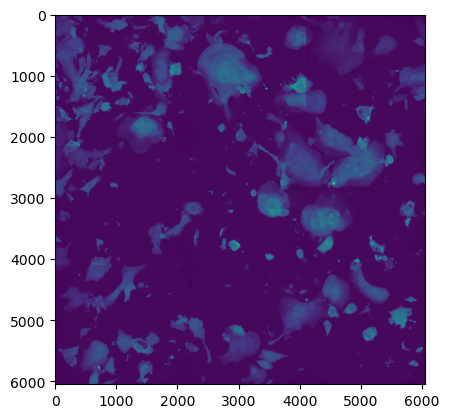

In [25]:
plt.imshow(images[0,1,0,...])

In [39]:
images.shape

(150, 2, 3, 6048, 6048)

In [37]:
max_proj = np.max(images, axis = 2)

In [43]:
base_dir

'/mnt/SYNO/macrohet_syno/ND0002/'

In [42]:
mtb_channel = 0
gfp_channel = 1
manual_mtb_thresh_channel = 2

In [ ]:
### iterate over positions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    acq_ID = (row, column)
    # tile images
    # images = tile.compile_mosaic(image_dir, 
    #                              metadata, 
    #                              row, 
    #                              column, 
    #                              set_plane = 'sum_proj',
    #                              )

    # process images using zarr
    image_dir = os.path.join(base_dir, f'acquisition/zarr/{acq_ID}.zarr')
    zarr_store = zarr.open(image_dir, mode='r')
    images = zarr_store.images
    max_projection = np.max(images, axis = 2)
    
    # check if already segmented using m2 model
#     if os.path.exists(os.path.join(base_dir, f'labels/macrohet_seg_model/{row, column}.h5')):
#         continue
#     else:
    
    # segment images from gfp channel only
    masks = np.stack([segment(frame) 
                      for frame in tqdm(images[:,gfp_channel,...],  # segmenting the GFP channel 
                                        desc = 'Segmenting')])
            
    # characterise Mtb growth using Otsu segmentation
    # otsu_mtb = otsu_threshold(images[:,1,...]) # time consuming and non-deterministic when compared to hardcoded, could result in different thresholds for same image? 
    # characterise Mtb growth using hardcoded threshold :S
    manual_mtb_thresh = np.where(images[:,mtb_channel,...] > Mtb_load_thresh, images[:,mtb_channel,...], 0)
    
    # reshape intensity image to be gfp, rfp on last axis for regionprops
    intensity_image = np.stack([images[:,0,...], 
                                images[:,1,...], 
#                                 otsu_mtb, 
                                manual_mtb_thresh], axis = -1)
    
    # localise objects
    objects = localise(masks, 
                       intensity_image, 
                       )

    # filter out small objects
    objects = [o for o in objects if o.properties['area'] > segment_size_thresh]
    
    # add label for infection
    for obj in objects:
        obj.properties = ({"Infected": True} 
                            if obj.properties['mean_intensity'][manual_mtb_thresh_channel] > 0 # index 2 for manual mtb channel 
                            else {"Infected": False})

    # track on upscaled config fn
    tracks = track(objects, masks, config_fn, search_radius = 20)

    # save out 
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/macrohet_seg_model/{row, column}_first_pass.h5'), 
                                       'w', 
                                       obj_type='obj_type_1'
                                       ) as writer:
#             writer.write_objects(objects)
            writer.write_tracks(tracks)
            writer.write_segmentation(masks)
    
#     notify.send_sms(f"Position {row, column} complete")

Progress through positions:   0%|          | 0/42 [00:00<?, ?it/s]

Segmenting:   0%|          | 0/150 [00:00<?, ?it/s]

In [10]:
### iterate over positions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):
    if (row, column) != (3, 4):
        continue
    # tile images
    images = tile.compile_mosaic(image_dir, 
                                 metadata, 
                                 row, 
                                 column, 
                                 set_plane = 'sum_proj',
                                 )
    
    # check if already segmented using m2 model
    if os.path.exists(os.path.join(base_dir, f'labels/macrohet_seg_model/{row, column}.h5')):
        # load previous segmentation
        with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/macrohet_seg_model/{row,column}.h5'),
                                       'r') as hdf:
            masks = hdf.segmentation
    else:
        # segment images from gfp channel only
        masks = np.stack([segment(frame) 
                          for frame in tqdm(images[:,0,...], 
                                            desc = 'Segmenting')])
            
    # characterise Mtb growth using Otsu segmentation
    # otsu_mtb = otsu_threshold(images[:,1,...]) # time consuming and non-deterministic when compared to hardcoded, could result in different thresholds for same image? 
    # characterise Mtb growth using hardcoded threshold :S
    manual_mtb_thresh = np.where(images[:,1,...] > Mtb_load_thresh, images[:,1,...], 0)
    
    # reshape intensity image to be gfp, rfp on last axis for regionprops
    intensity_image = np.stack([images[:,0,...], 
                                images[:,1,...], 
#                                 otsu_mtb, 
                                manual_mtb_thresh], axis = -1)
    
    # localise objects
    objects = localise(masks, 
                       intensity_image, 
                       )

    # filter out small objects
    objects = [o for o in objects if o.properties['area'] > segment_size_thresh]
    
    # add label for infection
    for obj in objects:
        obj.properties = ({"Infected": True} 
                            if obj.properties['mean_intensity'][2] > 0 
                            else {"Infected": False})

    # track on upscaled config fn
    tracks = track(objects, masks, config_fn, search_radius = 20)

    # save out 
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/macrohet_seg_model/{row, column}.h5'), 
                                       'w', 
                                       obj_type='obj_type_1'
                                       ) as writer:
#             writer.write_objects(objects)
            writer.write_tracks(tracks)
            writer.write_segmentation(masks)
    
#     notify.send_sms(f"Position {row, column} complete")

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

Segmenting:   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/05/22 02:00:23 AM] Localizing objects from segmentation...
100%|█████████████████████████████████████████████████████████████████████| 75/75 [15:59<00:00, 12.79s/it]
[INFO][2023/05/22 02:16:22 AM] Objects are of type: <class 'dict'>
[INFO][2023/05/22 02:16:22 AM] ...Found 45008 objects in 75 frames.
[INFO][2023/05/22 02:16:23 AM] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2023/05/22 02:16:23 AM] Starting BayesianTracker session
[INFO][2023/05/22 02:16:23 AM] Loading configuration file: /home/dayn/analysis/btrack/models/particle_config_pnassign.json
[INFO][2023/05/22 02:16:23 AM] Objects are of type: <class 'list'>
[INFO][2023/05/22 02:16:24 AM] Starting tracking... 
[INFO][2023/05/22 02:16:24 AM] Update using: ['MOTION', 'VISUAL']
[INFO][2023/05/22 02:16:24 AM] Tracking objects in frames 0 to 24 (of 75)...
[INFO][2023/05/22 02:16:35 AM]  - Timing (Bayesian updates: 120.03ms, Linking: 4.66ms)
[INFO][2023/05/22 02:16:35 AM]  - Probabilities (Li

GLPK Integer Optimizer 5.0
16720 rows, 14834 columns, 21308 non-zeros
14834 integer variables, all of which are binary
Preprocessing...
8360 rows, 14834 columns, 21308 non-zeros
14834 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 8360
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
8360 rows, 14834 columns, 21308 non-zeros
*     0: obj =   4.322022824e+04 inf =   0.000e+00 (4106)
Perturbing LP to avoid stalling [1597]...
Removing LP perturbation [4135]...
*  4135: obj =   1.928289890e+04 inf =   0.000e+00 (0) 1
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4135: mip =     not found yet >=              -inf        (1; 0)
+  4135: >>>>>   1.928289890e+04 >=   1.928289890e+04   0.0% (1; 0)
+  4135: mip =   1.928289890e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTI

[INFO][2023/05/22 02:16:52 AM] Ending BayesianTracker session
[INFO][2023/05/22 02:16:52 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2023/05/22 02:16:52 AM] Writing objects/obj_type_1
[INFO][2023/05/22 02:16:52 AM] Writing labels/obj_type_1
[INFO][2023/05/22 02:16:52 AM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/05/22 02:16:53 AM] Writing properties/obj_type_1/area (39878,)
[INFO][2023/05/22 02:16:53 AM] Writing properties/obj_type_1/major_axis_length (39878,)
[INFO][2023/05/22 02:16:53 AM] Writing properties/obj_type_1/minor_axis_length (39878,)
[INFO][2023/05/22 02:16:53 AM] Writing properties/obj_type_1/orientation (39878,)
[INFO][2023/05/22 02:16:53 AM] Writing properties/obj_type_1/mean_intensity (39878, 3)
[INFO][2023/05/22 02:16:53 AM] Writing properties/obj_type_1/Infected (39878,)
[INFO][2023/05/22 02:16:53 AM] Writing tracks/obj_type_1
[INFO][2023/05/22 02:16:53 AM] Writing dummies/obj_type_1
[INFO][202